# Homework 6

##### Data: HW6_data.csv

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 20th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [2]:
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

## Question 1: Can I sample from F-R-I-E-N-D-S without rejection?  It's Important!

**Coding required**


*Haven't we made it obvious?* In HW 5 we were introduced to $X$ a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

*Haven't we made it clear?*  We were also introduced to $h$ the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


*Want us to spell it out for you?* Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)

**1.2.** Importance sampling with a uniform proposal distribution

**1.3.** Importance sampling with a normal proposal distribution and appropriately chosen parameters

--

**1.4.** So far (in HWs 5 and 6) we've computed estimates of $\mathbb{E}[h(X)]$ for the following list of methods:

* Inverse Transform Sampling
* Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)
* Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)
* Importance sampling with a uniform proposal distribution
* Importance sampling with a normal proposal distribution and appropriately chosen parameters.

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ you calculated in this list. Which sampling methods and associated proposal distributions would you expect based on discussions from lecture to have resulted in lower variances? How well do your results align with these expectations?

**Gratuitous Titular Reference**:  Annemarie and Marshmello's [F-R-I-E-N-D-S](https://www.youtube.com/watch?v=CY8E6N5Nzec) samples from French Hip Hop artist Rapsa's [42 Mesures à ta Sa(i)nté](https://www.youtube.com/watch?v=JivaoPSAgLI) a homage to his hometown of Saint-Étienne.

<div class="answer-separator">
------------------------
</div>

#### Solutions

##### 1.1

Since we already know a lot about this function, we can easily set the best values for our proposal distribution and for $M$. 

In [3]:
from scipy.stats import norm
import time

In [4]:
def pdf(x):
    if x < 1 or x > 9:
        return 0.
    elif x >= 1 and x <= 3:
        return 1/12. * (x - 1)
    elif x > 3 and x <= 5:
        return -1/12. * (x - 5)
    elif x > 5 and x <= 7:
        return 1/6. * (x - 5)
    elif x > 7 and x <= 9:
        return -1/6. * (x - 9)

In [5]:
def h(x):
    denom = (3. * np.sqrt(2) * np.pi)
    num = np.exp(-(x - 5)**2 / 18)
    return num / denom

For our proposal distribution, I've empirically found an appropriate standard deviation of 3.5, centered at the pdf's optimum and with an $M$ selected to make the optima of the two functions meet (shown below).

In [6]:
n_samples = 10000

In [7]:
prop_std = 2.5
prop = norm(loc=6, scale=prop_std)
M = pdf(7) / prop.pdf(7)

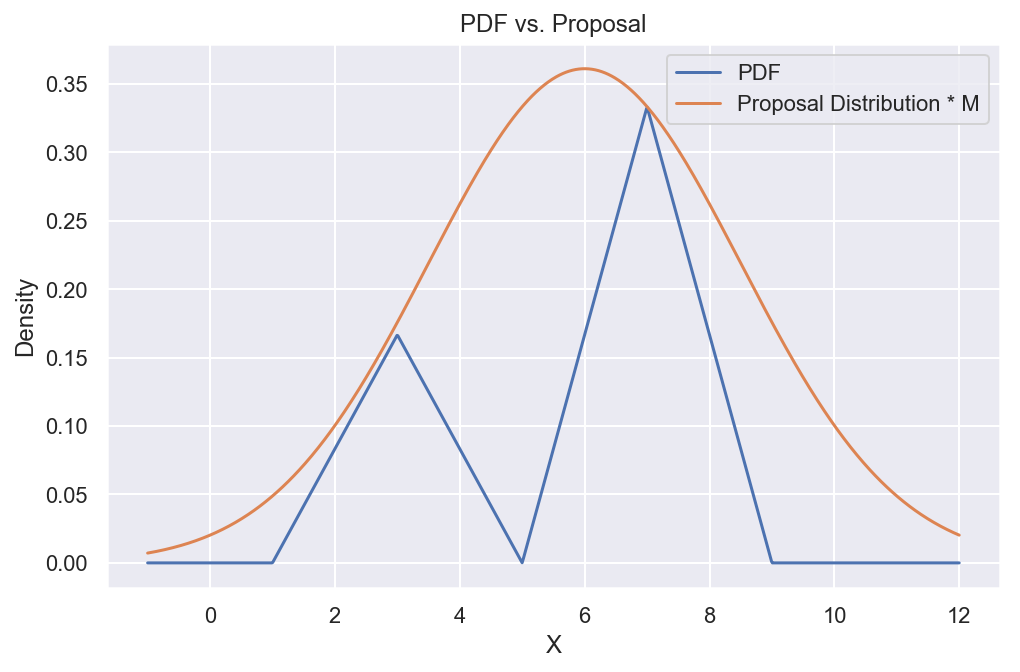

In [8]:
x = np.linspace(-1, 12, 1000)
plt.subplots(figsize=(8, 5))
plt.plot(x, [pdf(xi) for xi in x], label='PDF')
plt.plot(x, prop.pdf(x) * M, label='Proposal Distribution * M')
plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.title('PDF vs. Proposal')
plt.show()

With this setup, we can now do the sampling and expectation:

In [9]:
def rejection_expectation(pdf, prop, n_samples, M):
    start = time.time()
    n_samples = 10000
    samples = []
    draws = 0
    while len(samples) < n_samples:
        n = n_samples - len(samples)
        draws += n
        x = prop.rvs(size=n)
        y = np.random.uniform(0, 1, size=n)
        accepted = y < (np.array([pdf(xi) for xi in x]) / prop.pdf(x) / M)
        samples += list(x[accepted])
    samples = np.array(samples)

    accept_rate = 100 * n_samples / draws
    expectation = np.mean(h(samples))
    elapsed = time.time() - start
    return expectation, accept_rate, elapsed

In [10]:
expectation, accept_rate, elapsed = rejection_expectation(pdf, prop, n_samples, M)

In [11]:
print(f'Expectation: {expectation:0.4f}')
print(f'Acceptance rate: {accept_rate:0.1f}%')
print(f'Sampling/calculation time for {n_samples} samples: {elapsed:0.3f} seconds')

Expectation: 0.0590
Acceptance rate: 44.3%
Sampling/calculation time for 10000 samples: 0.115 seconds


##### 1.2

In [44]:
from scipy.stats import uniform

In [45]:
prop = uniform(loc=1, scale=8)

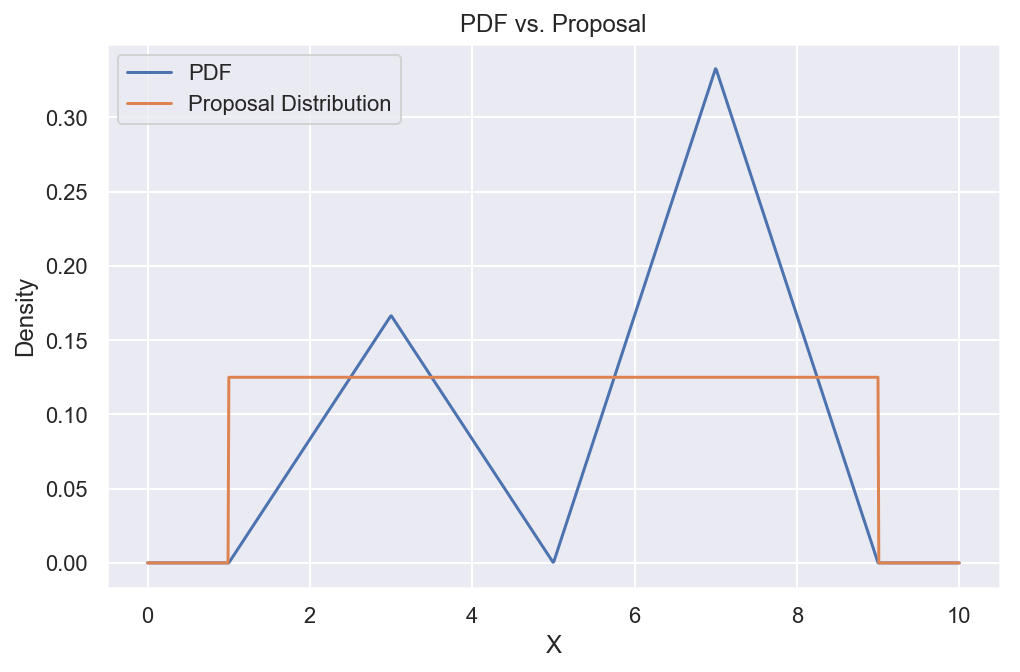

In [46]:
x = np.linspace(0, 10, 1000)
plt.subplots(figsize=(8, 5))
plt.plot(x, [pdf(xi) for xi in x], label='PDF')
plt.plot(x, prop.pdf(x), label='Proposal Distribution')
plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.title('PDF vs. Proposal')
plt.show()

In [15]:
def importance_expectation(pdf, prop, n_samples):
    begin = time.time()
    n_samples = 10000
    samples = prop.rvs(size=n_samples)

    samp_density = np.array([pdf(x) for x in samples])
    w = samp_density / prop.pdf(samples)
    expectation = np.mean(h(samples) * w)
    elapsed = time.time() - begin
    return expectation, elapsed

In [16]:
expecation, elapsed = importance_expectation(pdf, prop, n_samples)

In [17]:
print(f'Expectation: {expectation:0.4f}')
print(f'Sampling/calculation time for {n_samples} samples: {elapsed:0.3f} seconds')

Expectation: 0.0590
Sampling/calculation time for 10000 samples: 0.024 seconds


##### 1.3

For my proposal distirbution, I tried to pick parameters that would cover the support of the pdf so that the entire pdf would have samples with which to perform the expectation, while keeping the proposal density as low as possible in 0-density regions. I found a mean of 5 and std deviation of 2, visualized below.

In [18]:
prop_std = 2.
prop = norm(loc=5, scale=prop_std)

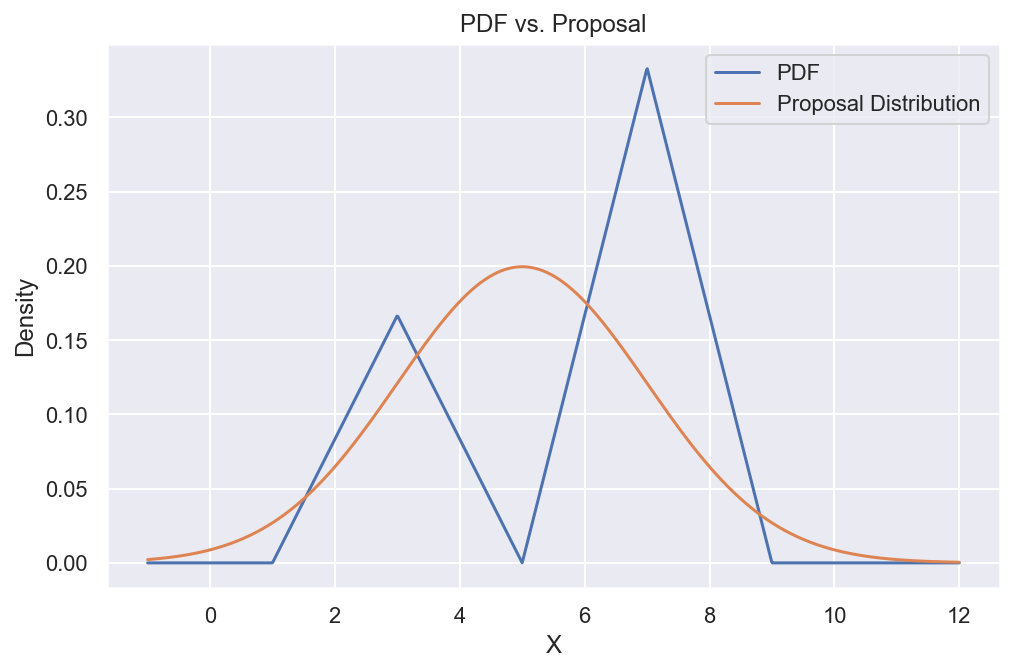

In [19]:
x = np.linspace(-1, 12, 1000)
plt.subplots(figsize=(8, 5))
plt.plot(x, [pdf(xi) for xi in x], label='PDF')
plt.plot(x, prop.pdf(x), label='Proposal Distribution')
plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.title('PDF vs. Proposal')
plt.show()

In [20]:
expectation, elapsed = importance_expectation(pdf, prop, n_samples)

In [21]:
print(f'Expectation: {expectation:0.4f}')
print(f'Sampling/calculation time for {n_samples} samples: {elapsed:0.3f} seconds')

Expectation: 0.0593
Sampling/calculation time for 10000 samples: 0.031 seconds


##### 1.4

I approach this problem by doing repeated experiments of the expectations for each. Starting with inverse transform, taking the inverse function I calculated on the previous homework:

In [22]:
repetitions = 1000

In [23]:
def inv_cdf(u):
    # assumes u is in proper range
    if u >= 2/3.:
        return -np.sqrt(12*(1-u)) + 9
    elif u >= 1/3.:
        return 2*np.sqrt(3*u - 1) +5
    elif u >= 1/6.:
        return 5 - 2*np.sqrt(2 - 6*u)
    else:
        return 1 + 2*np.sqrt(6*u)

In [24]:
def inverse_transform_sample(n, inv_cdf):
    r = np.random.uniform(0, 1, n)
    return np.array([inv_cdf(ri) for ri in r])

In [25]:
def mc_expectation(f, samples):
    return f(samples).mean()

In [26]:
inv_exps = []
for i in range(repetitions):
    samples = inverse_transform_sample(n_samples, inv_cdf)
    inv_exps.append(mc_expectation(h, samples))

In [27]:
inv_var = np.var(inv_exps)

Repeat with the uniform rejection sampling:

In [28]:
prop = uniform(loc=1, scale=8)

In [29]:
urej_exps = []
for i in range(repetitions):
    exp, _, _ = rejection_expectation(pdf, prop, n_samples, 1)
    urej_exps.append(exp)

In [30]:
urej_var = np.var(urej_exps)

Next, normal rejection sampling:

In [31]:
prop_std = 2.5
prop = norm(loc=6, scale=prop_std)
M = pdf(7) / prop.pdf(7)

In [32]:
rej_exps = []
for i in range(repetitions):
    exp, _, _ = rejection_expectation(pdf, prop, n_samples, M)
    rej_exps.append(exp)

In [33]:
rej_var = np.var(rej_exps)

Next uniform importance sampling:

In [34]:
prop = uniform(loc=1, scale=8)

In [35]:
uniform_exps = []
for i in range(repetitions):
    exp, _ = importance_expectation(pdf, prop, n_samples)
    uniform_exps.append(exp)

In [36]:
uniform_var = np.var(uniform_exps)

And finally, normal importance sampling:

In [37]:
prop_std = 2.
prop = norm(loc=5, scale=prop_std)

In [38]:
normal_exps = []
for i in range(repetitions):
    exp, _ = importance_expectation(pdf, prop, n_samples)
    normal_exps.append(exp)

In [39]:
normal_var = np.var(normal_exps)

And compare the results:

In [41]:
variances = {
    'Inverse Transform': inv_var,
    'Uniform Rejection': urej_var,
    'Normal Rejection': rej_var,
    'Uniform Importance': uniform_var,
    'Normal Importance': normal_var
}

In [47]:
pd.DataFrame.from_dict(variances, orient='index', columns=['Expectation Variance'])

,Expectation Variance
Inverse Transform,1.023609e-08
Uniform Rejection,1.334597e-08
Normal Rejection,1.008284e-08
Uniform Importance,2.033983e-07
Normal Importance,1.958474e-07


I would expect that inverse transform sampling and both methods of rejection sampling would have the same overall variance. They produce samples in different ways, but each of these produce valid and representative samples which are all weighted the same way in producing monte carlo estimates. This is supported by my experiments, which show very similar variance estimates for each.

For importance sampling, I would expect the proposal distribution to matter much more. A poor proposal distribution could cause undersampling of some high-density regions of the pdf, which would cause greater variability in the estimates drawn from those regions. The weighting attempts to compensate for this, but is imperfect unless $n\rightarrow \infty$. Thus finding a representative proposal distirbution will reduce the estimates' variance. In our case, both proposal distributions are decent but not entirely representative, and we therefore see somewhat higher variance in the importance sampling estimates.

## Question 2: Mr. Poe Writes of Gradient Descent Into the Maelström`

Suppose you are building a pricing model for laying down telecom cables over a geographical region. You construct a pricing model that takes as input a pair of coordinates, $(x_1, x_2)$ and based upon two parameters $\lambda_1, \lambda_2$ predicts the loss in revenue corresponding to laying the cables at the inputed location.  Your pricing model is described by the following equation:

$$
\mathcal{L}(x_1, x_2\ \vert\ \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x_1 + 0.003926\lambda_1 x_1\exp\left\{\left(x_2^2 - x_1^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

We've provided you some data contained in the file `HW6_data.csv`. This data represents a set of coordinates configured on the curve $x_2^2 - x_1^2 = -0.1$. Your general goal for this problem is to find the parameters $\lambda_1, \lambda_2$ that  minimize the net loss over the entire dataset.

**2.1.** Construct an appropriate visualization of the loss function for the given data.  Use that visualization to verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized.  Your visualization should make note of this optima.

**2.2.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should be stored in a function named `gradient_descent`.  `gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates used in your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `gradient_descent`
    
The return value for `gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration


**2.3** For your implementation in 2.2, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

**2.4.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement stochastic gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should a stored in a function named `stochastic_gradient_descent`.  `stochastic_gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates for your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `stochastic_gradient_descent`
    
The return value for `stochastic_gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration


**2.5** For your implementation in 2.4, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

**2.6** Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

**2.7** Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3`.  You may wish to set a cap for maximum number of iterations.  Which method converges to the optimal point in fewer iterations?  Briefly explain why this result should be expected.

**2.8** Compare the performance of stochastic gradient descent on our loss function and dataset for the following learning rates: [10, 1, 0.1, 0.01, 0.001, 0.0001]. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

**2.9** Using your implementation of gradient descent and stochastic gradient descent, document the behavior of your two algorithms for the following starting points, and for a number of stepsizes of your choice:

- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$

Construct a mathematical analysis of the loss function $\mathcal{L}$ to explain results of your descent algorithms at different starting points.

**Gratuitous Titular Reference**:  The renowned American auteur Edgar Allen Poe penned ["A Descent into the Maelström"](https://en.wikipedia.org/wiki/A_Descent_into_the_Maelstr%C3%B6m), a macabre tale of a seemingly elderly man's surviving a previous horrendous encounter with a massive hurricane, a shipwreck and a sea vortex, in 1841.

<div class="answer-separator">
------------------------
</div>

2.9, just explain intuitively/visually, "mathematic" analysis